# Importing the necessary libraries and loading the data

In [54]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats import mstats
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (9,6)

In [38]:
# loading the data

historical_data = pd.read_csv('/content/historical_data.csv')
sentiment_data = pd.read_csv('/content/fear_greed_index.csv')


print(historical_data.head(), historical_data.info())
print(sentiment_data.head(), sentiment_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

# Preprocessing the data


In [39]:

historical_data['Timestamp IST'] = pd.to_datetime(historical_data['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
historical_data['date'] = historical_data['Timestamp IST'].dt.date

# Sentiment date
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], errors='coerce').dt.date

# checking ranges
s_date = historical_data['date'].min()
e_date = historical_data['date'].max()
print('Historical range:', s_date, 'to', e_date)
print('Sentiment range:', sentiment_data['date'].min(), 'to', sentiment_data['date'].max())

# Filter sentiment to overlapping dates
sentiment_data = sentiment_data[(sentiment_data['date'] >= s_date) & (sentiment_data['date'] <= e_date)]

Historical range: 2023-05-01 to 2025-05-01
Sentiment range: 2018-02-01 to 2025-05-02


`Merging both the datasets on 'date' column so as to know the sentiment on the trading day. `

In [40]:
# merging the datasets and handlling missing data after merging
# merging (left join to keep all trades)
df_merged = pd.merge(historical_data, sentiment_data[['date','value','classification']], on='date', how='left')

# showing missing sentiment days
missing_sent = df_merged[df_merged['value'].isna()]['date'].drop_duplicates()
print('Dates with missing sentiment (samples):', missing_sent.head().tolist())

# Forward-fill sentiment
df_merged['value'] = df_merged['value'].fillna(method='ffill')
df_merged['classification'] = df_merged['classification'].fillna(method='ffill')


Dates with missing sentiment (samples): [datetime.date(2024, 10, 26)]


```
Values corresponding to date 26/10/2024 are missing.
We can use the fillna() with 'ffill' method so as to fill the values.
Cross checking from the sentiment dataset, the sentiment on days preceeding and proceeding the date 26/10/2024
were same i.e., 'Greedy'.
```



In [69]:
# creating Profitable column
if 'Profitable' not in df_merged.columns:
    df_merged['Profitable'] = df_merged['Closed PnL'] > 0

print(df_merged[['Closed PnL','Size USD']].describe())

          Closed PnL      Size USD
count  211224.000000  2.112240e+05
mean       48.749001  5.639451e+03
std       919.164828  3.657514e+04
min   -117990.104100  0.000000e+00
25%         0.000000  1.937900e+02
50%         0.000000  5.970450e+02
75%         5.792797  2.058960e+03
max    135329.090100  3.921431e+06


# Feature Engineering

In [59]:
# FEATURE ENGINEERING
df_merged['log_size'] = np.log1p(df_merged['Size USD'].fillna(0))

# pnl per usd

df_merged['pnl_per_usd'] = df_merged['Closed PnL'].div(df_merged['Size USD'].replace(0, np.nan).fillna(1e-9))

# absolute pnl

df_merged['abs_pnl'] = df_merged['Closed PnL'].abs()
df_merged['ClosedPnL_winsor'] = mstats.winsorize(df_merged['Closed PnL'].fillna(0), limits=[0.01,0.01])

# hour_of_day from Timestamp IST
df_merged['hour'] = df_merged['Timestamp IST'].dt.hour


In [73]:
# summary statistics of pnl per usd by sentiment
df_grouped_pnl_per_usd = df_merged.groupby('classification')['pnl_per_usd'].describe()
print(df_grouped_pnl_per_usd)

                  count      mean       std         min  25%  50%       75%  \
classification                                                                
Extreme Fear    21400.0  0.004321  0.095705   -1.435997  0.0  0.0  0.008771   
Extreme Greed   39992.0  0.040015  1.929376 -384.406426  0.0  0.0  0.029008   
Fear            61837.0  0.015409  0.072819   -1.361753  0.0  0.0  0.007346   
Greed           50309.0  0.019704  0.099754   -3.100918  0.0  0.0  0.010610   
Neutral         37686.0  0.009936  0.175546  -23.359398  0.0  0.0  0.007872   

                     max  
classification            
Extreme Fear    3.403550  
Extreme Greed   1.000357  
Fear            2.604130  
Greed           1.487955  
Neutral         1.366625  


# Exploratory Visuals and Statistical tests

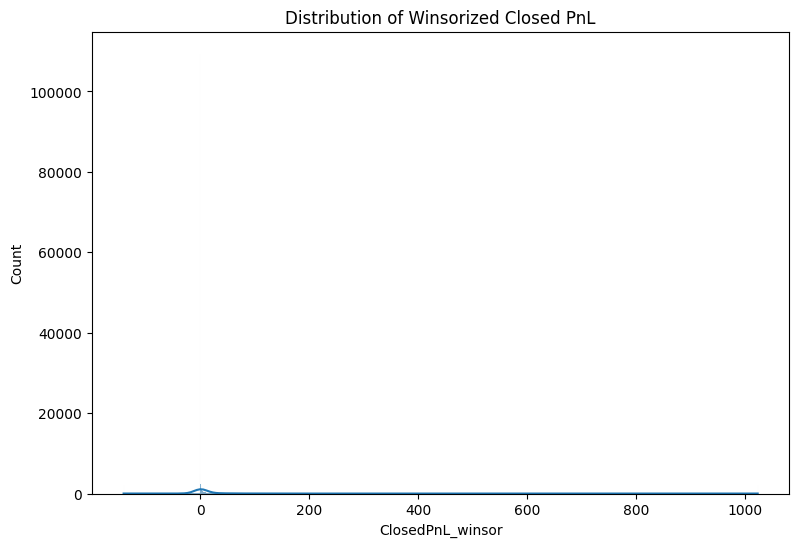

In [76]:
sns.histplot(x='ClosedPnL_winsor', data=df_merged, kde=True)
plt.title('Distribution of Winsorized Closed PnL')
plt.show()

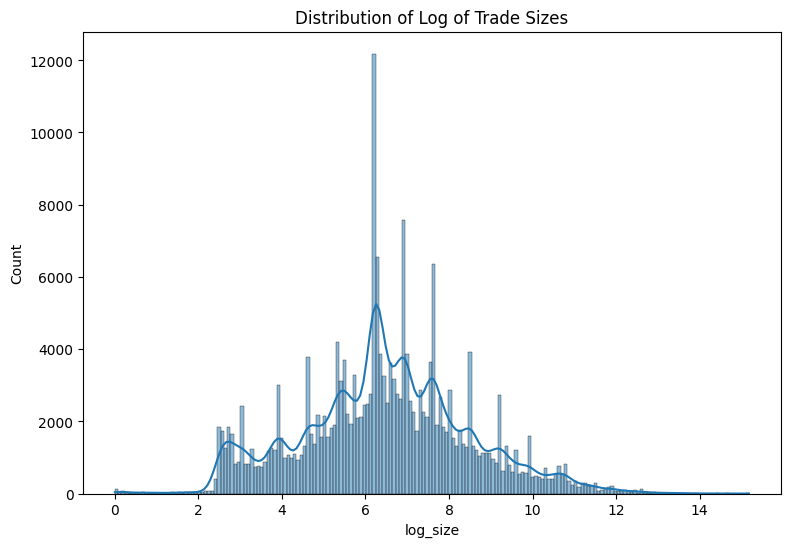

In [60]:
sns.histplot(x='log_size', data=df_merged, kde=True)
plt.title('Distribution of Log of Trade Sizes')
plt.show()

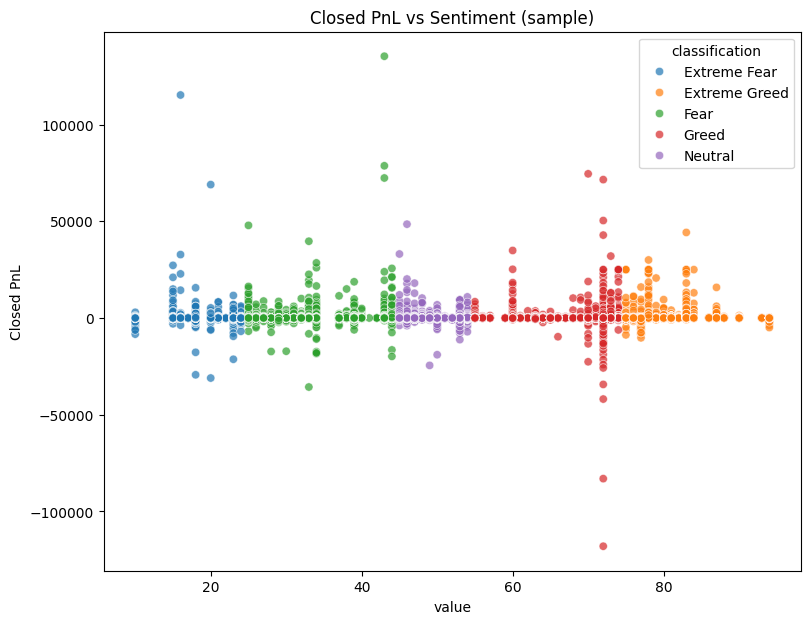

In [75]:
# scatter Closed PnL vs sentiment value
plt.figure(figsize=(9,7))
sns.scatterplot(data=df_merged, x='value', y='Closed PnL', hue='classification', alpha=0.7)
plt.title('Closed PnL vs Sentiment (sample)')
plt.show()

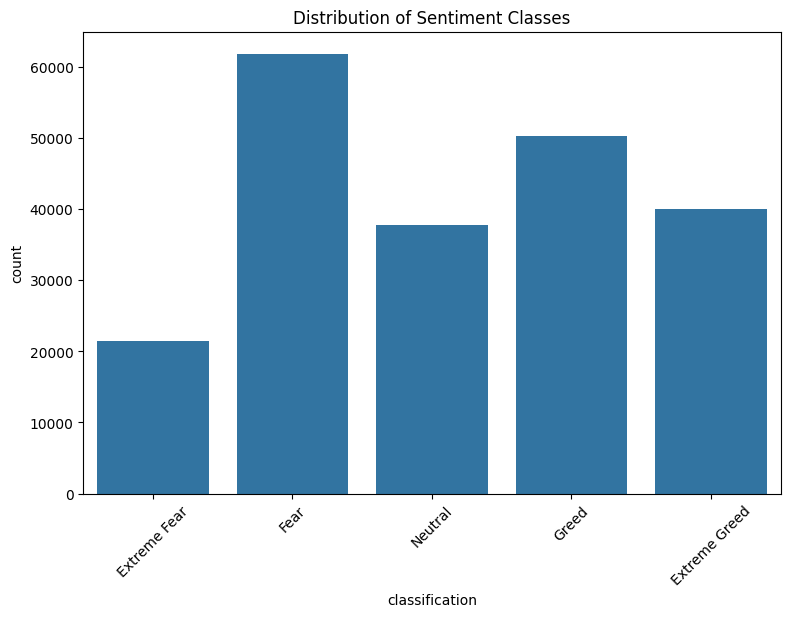

In [63]:
# distribution of sentiment classes

order = ['Extreme Fear','Fear','Neutral','Greed','Extreme Greed']
plt.figure()
sns.countplot(x='classification', data=df_merged, order=order)
plt.xticks(rotation=45)
plt.title('Distribution of Sentiment Classes')
plt.show()

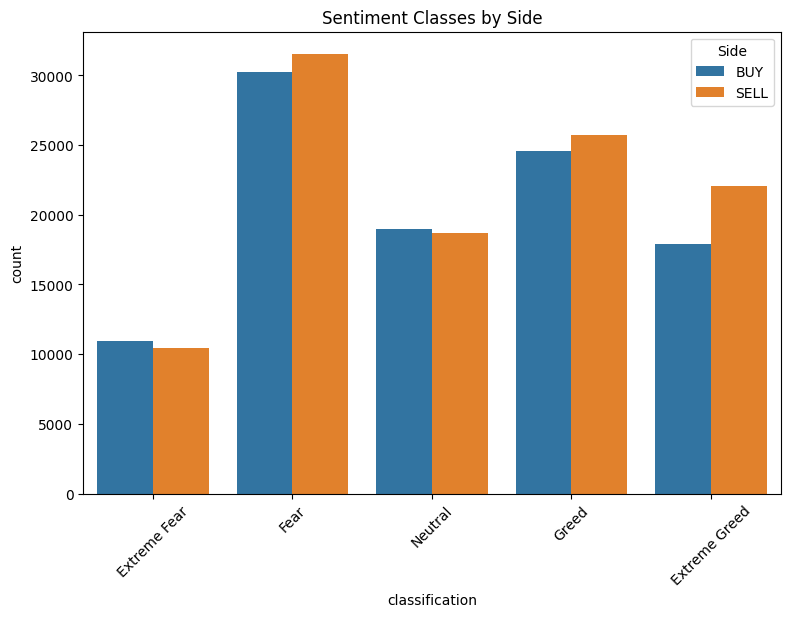

In [64]:
# BUY vs SELL by sentiment

plt.figure()
sns.countplot(x='classification', hue='Side', data=df_merged, order=order)
plt.xticks(rotation=45)
plt.title('Sentiment Classes by Side')
plt.show()

In [66]:
# aggregating by sentiment

agg_sent = df_merged.groupby('classification').agg(
    trades=('date','count'),
    size_median=('Size USD','median'),
    size_mean=('Size USD','mean'),
    closedpnl_median=('Closed PnL','median'),
    closedpnl_mean=('Closed PnL','mean'),
    pct_profitable=('Profitable','mean')
).sort_index()

print('\nAggregated metrics by sentiment:')
print(agg_sent)


Aggregated metrics by sentiment:
                trades  size_median    size_mean  closedpnl_median  \
classification                                                       
Extreme Fear     21400      766.150  5349.731843               0.0   
Extreme Greed    39992      500.050  3112.251565               0.0   
Fear             61837      735.960  7816.109931               0.0   
Greed            50309      555.000  5737.962662               0.0   
Neutral          37686      547.655  4782.732661               0.0   

                closedpnl_mean  pct_profitable  
classification                                  
Extreme Fear         34.537862        0.370607  
Extreme Greed        67.892861        0.464943  
Fear                 54.290400        0.420768  
Greed                43.582684        0.384901  
Neutral              34.307718        0.396991  


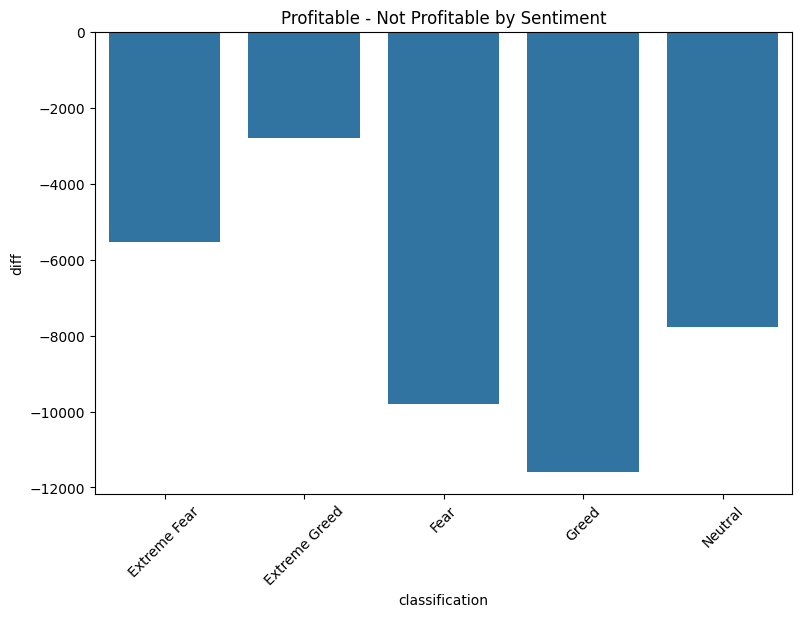

In [62]:
# profitable vs not profitable
profitable_counts = df_merged.groupby(['classification','Profitable']).size().unstack(fill_value=0)
profitable_counts['diff'] = profitable_counts[True] - profitable_counts[False]
profitable_counts = profitable_counts.reset_index()
plt.figure()
sns.barplot(data=profitable_counts, x='classification', y='diff')
plt.title('Profitable - Not Profitable by Sentiment')
plt.xticks(rotation=45)
plt.show()



Daily correlation :
                 sentiment_value  total_volume  total_pnl  pct_profitable
sentiment_value         1.000000     -0.264727  -0.082209        0.154706
total_volume           -0.264727      1.000000   0.325447        0.046262
total_pnl              -0.082209      0.325447   1.000000        0.170511
pct_profitable          0.154706      0.046262   0.170511        1.000000


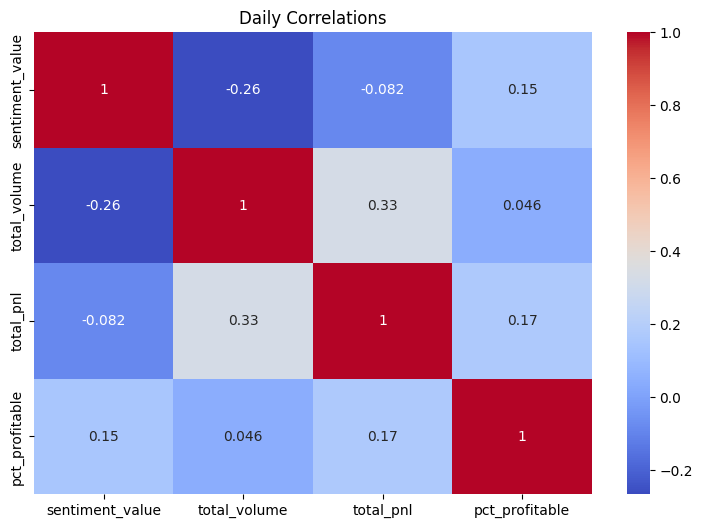

In [67]:
# daily aggregation and correlation

daily = df_merged.groupby('date').agg(
    sentiment_value = ('value','first'),
    total_volume = ('Size USD','sum'),
    total_pnl = ('Closed PnL','sum'),
    avg_crossed = ('Crossed','mean') ,
    pct_profitable = ('Profitable','mean')
)

daily = daily.reset_index()

# correlation
corr_cols = ['sentiment_value','total_volume','total_pnl','pct_profitable']
print('\nDaily correlation :')
print(daily[corr_cols].corr())

plt.figure()
sns.heatmap(daily[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Daily Correlations')
plt.show()

Best lag (days): -24 corr: -0.181414647915319


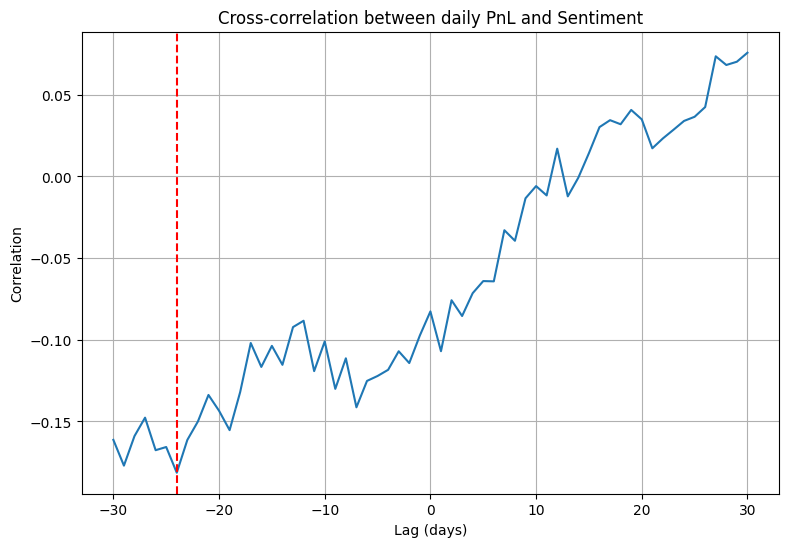

In [47]:
# lagged sentiment & cross-correlation (detecting delayed effects)

# preparing daily sentiment series
sent_daily = sentiment_data[['date','value']].drop_duplicates().set_index('date').sort_index()
# create lags and rolling
for lag in [1,2,3,7]:
    sent_daily[f'lag_{lag}'] = sent_daily['value'].shift(lag)
sent_daily['roll7'] = sent_daily['value'].rolling(7, min_periods=1).mean()

# merge back to daily
daily = daily.merge(sent_daily.reset_index(), on='date', how='left')

# cross-correlation simple scan
ser_pnl = daily.set_index('date')['total_pnl']
ser_sent = daily.set_index('date')['value']

lags = range(-30,31)
ccf = [ser_pnl.corr(ser_sent.shift(l)) for l in lags]
best_idx = np.nanargmax(np.abs(ccf))
print('Best lag (days):', lags[best_idx], 'corr:', ccf[best_idx])

plt.figure()
plt.plot(lags, ccf)
plt.axvline(x=lags[best_idx], color='red', linestyle='--')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.title('Cross-correlation between daily PnL and Sentiment')
plt.grid(True)
plt.show()

Sentiment classes present: ['Extreme Greed', 'Extreme Fear', 'Fear', 'Greed', 'Neutral']
Greed vs Fear Welch t-test p-value: 0.08676370484115542
Chi-square p-value: 1.963233701803456e-176

Contingency table (classification vs profitable):


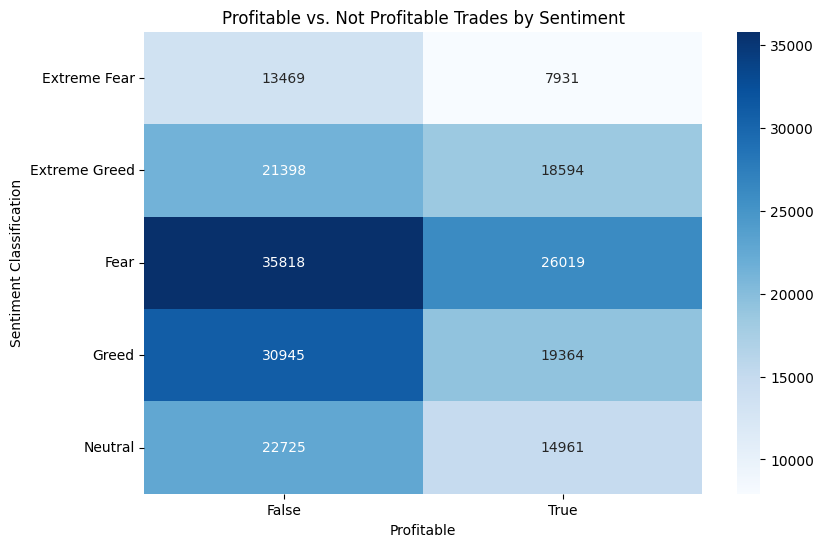

In [48]:
# Statistical tests

classes_present = df_merged['classification'].dropna().unique().tolist()
print('Sentiment classes present:', classes_present)

greed = df_merged[df_merged['classification']=='Greed']['Closed PnL'].dropna()
fear = df_merged[df_merged['classification']=='Fear']['Closed PnL'].dropna()
tstat, pval = stats.ttest_ind(greed, fear, equal_var=False, nan_policy='omit')
print('Greed vs Fear Welch t-test p-value:', pval)


# proportion test: percent profitable differs across classes (chi-sq)

ct = pd.crosstab(df_merged['classification'], df_merged['Profitable'])
chi2, p, dof, ex = stats.chi2_contingency(ct)
print('Chi-square p-value:', p)
print('\nContingency table (classification vs profitable):')
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Profitable vs. Not Profitable Trades by Sentiment')
plt.xlabel('Profitable')
plt.ylabel('Sentiment Classification')
plt.show()
